In [1]:
#https://keras.io/optimizers/
#https://medium.com/@wilamelima/analysing-bike-sharing-trends-with-python-a9f574c596b9
## http://www.analyzingdata.org/portfolio/001-Bike-sharing/
##https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/
# https://datascienceplus.com/keras-regression-based-neural-networks/
# https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-regression-ceee5a9eadff

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  #0 for activate , -1 for deactivate

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense
from keras.layers import LeakyReLU
import tensorflow as tf
from keras import layers

Using TensorFlow backend.


In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
data = pd.read_csv('hour.csv')
print(data.shape)

(17379, 17)


In [4]:
data.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
#sn.pairplot(data)

In [6]:
data.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

In [7]:
data['season'] = data.season.astype('category')
data['month'] = data.month.astype('category')
data['hour'] = data.hour.astype('category')
data['holiday'] = data.holiday.astype('category')
data['weekday'] = data.weekday.astype('category')
data['workingday'] = data.workingday.astype('category')
data['weather'] = data.weather.astype('category')

data.dtypes

instant          int64
dteday          object
season        category
yr               int64
month         category
hour          category
holiday       category
weekday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity       float64
windspeed      float64
casual           int64
registered       int64
count            int64
dtype: object

In [8]:
data.isnull().any()

instant       False
dteday        False
season        False
yr            False
month         False
hour          False
holiday       False
weekday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
casual        False
registered    False
count         False
dtype: bool

[Text(0.5, 1.0, 'Monthly distribution')]

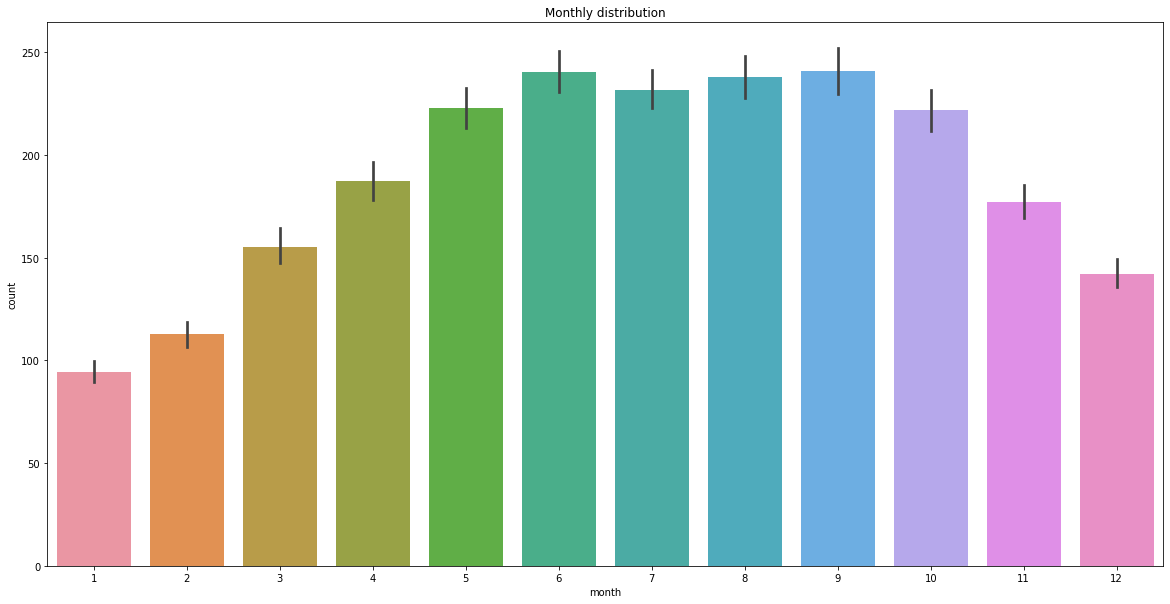

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
sn.barplot(data=data[['month',
                      'count']],
            x='month', y='count')
ax.set(title="Monthly distribution")

[Text(0.5, 1.0, 'Daily distribution')]

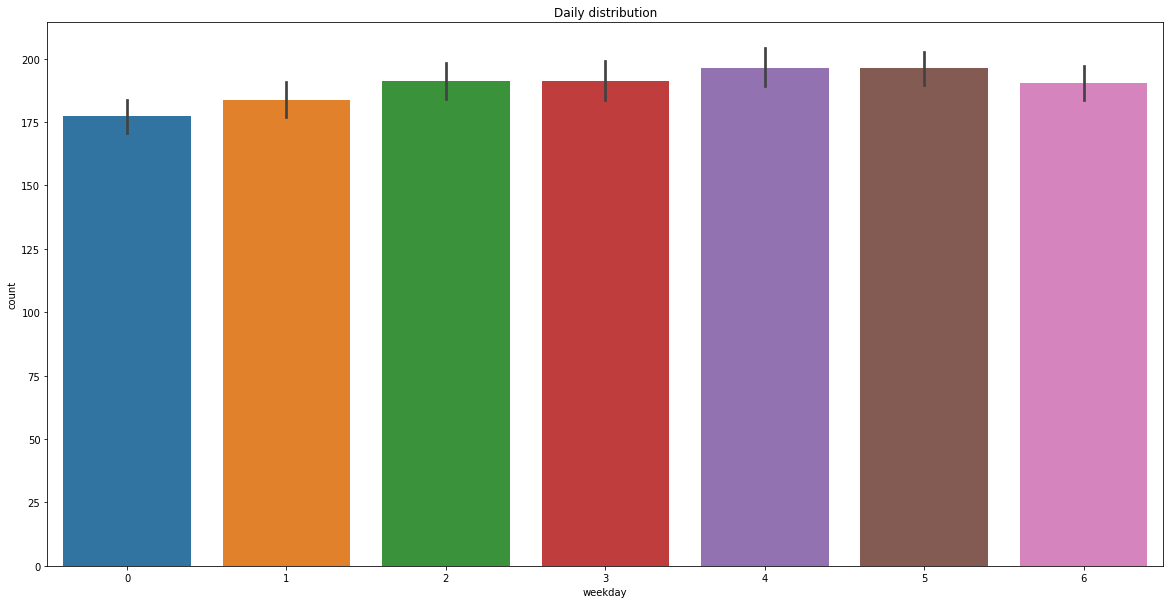

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
sn.barplot(data=data[['weekday',
                      'count']],
            x='weekday', y='count')
ax.set(title="Daily distribution")

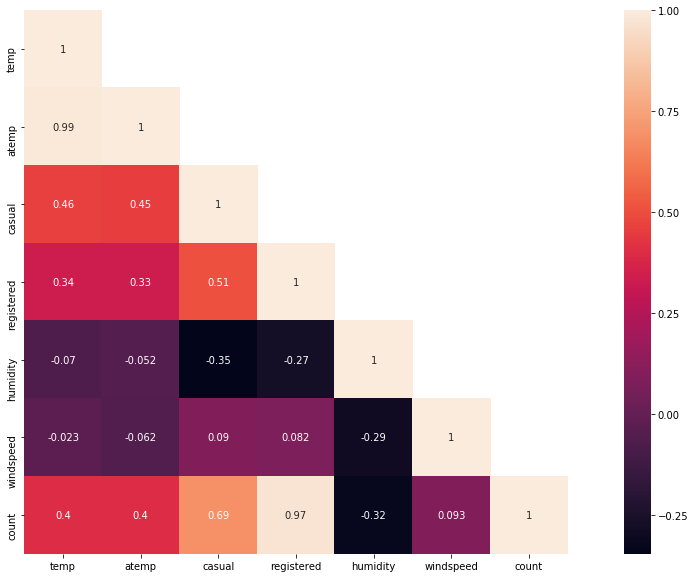

In [10]:
data_correlation = data[['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']].corr()
mask = np.array(data_correlation)
mask[np.tril_indices_from(mask)] = False
fig = plt.subplots(figsize=(20,10))
sn.heatmap(data_correlation, mask=mask, vmax=1, square=True, annot=True)

In [11]:
data = data.drop(['instant','dteday','yr',  'casual', 'registered', 'windspeed'], axis=1)

drop registered กับ count เพราะ อยากทำนายแค่ count
,temp กับ atemp มีcorrelationสูง จึงdropไปอันนึง    
windspeed correlationต่ำ กับ count 

In [12]:
data.shape

(17379, 11)

In [13]:
data.head()

,season,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,count
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,16
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,40
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,32
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,13
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,1


In [14]:
data_dummy = data
def dummify_dataset(df, column):       
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column, drop_first=True)],axis=1)
    df = df.drop([column], axis=1)
    return df
columns_to_dummify = ['season', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather']
for column in columns_to_dummify:
    data_dummy = dummify_dataset(data_dummy, column)
data_dummy.columns

Index(['temp', 'atemp', 'humidity', 'count', 'season_2', 'season_3',
       'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'holiday_1', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'workingday_1', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


(array([0.01323436, 0.03164739, 0.40048334, 0.85217792, 1.51965015,
        1.7745555 , 1.69169688, 1.37177053, 1.66868059, 0.67610334]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

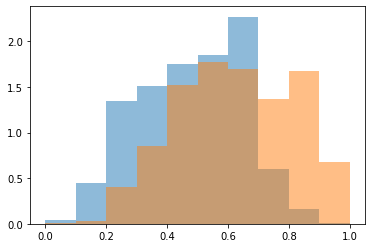

In [15]:
plt.hist(data_dummy['atemp'], normed=True, alpha=0.5)
plt.hist(data_dummy['humidity'], normed=True, alpha=0.5)

In [16]:
X = data_dummy.drop(['count'], axis=1)

y = data_dummy["count"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [18]:
X.shape

(17379, 51)

In [19]:
classifier = Sequential()
classifier.add(Dense(units = 20 , kernel_initializer = 'normal', activation = 'relu', input_dim = 51))
classifier.add(Dense(units = 18, activation = 'relu'))
classifier.add(Dense(units = 10, activation = 'relu'))
classifier.add(Dense(units = 1))

W0916 00:43:32.068922  1316 deprecation_wrapper.py:119] From C:\Users\peravit2\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0916 00:43:32.141706  1316 deprecation_wrapper.py:119] From C:\Users\peravit2\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 00:43:32.155669  1316 deprecation_wrapper.py:119] From C:\Users\peravit2\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4409: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0916 00:43:32.186586  1316 deprecation_wrapper.py:119] From C:\Users\peravit2\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [20]:
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse'])

W0916 00:43:34.106906  1316 deprecation_wrapper.py:119] From C:\Users\peravit2\Anaconda3\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [21]:
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

W0916 00:43:34.556619  1316 deprecation_wrapper.py:119] From C:\Users\peravit2\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/100
13903/13903 [==============================] - 9s 666us/step - loss: 19177.2831 - mean_squared_error: 19177.2831
Epoch 2/100
13903/13903 [==============================] - 5s 327us/step - loss: 7724.3462 - mean_squared_error: 7724.3462
Epoch 3/100
13903/13903 [==============================] - 4s 305us/step - loss: 6164.3210 - mean_squared_error: 6164.3210
Epoch 4/100
13903/13903 [==============================] - 4s 301us/step - loss: 5787.4275 - mean_squared_error: 5787.4275
Epoch 5/100
13903/13903 [==============================] - 4s 286us/step - loss: 5635.4844 - mean_squared_error: 5635.4844
Epoch 6/100
13903/13903 [==============================] - 4s 300us/step - loss: 5536.2150 - mean_squared_error: 5536.2150
Epoch 7/100
13903/13903 [==============================] - 4s 301us/step - loss: 5475.7804 - mean_squared_error: 5475.7804
Epoch 8/100
13903/13903 [==============================] - 4s 277us/step - loss: 5386.1402 - mean_squared_error: 5386.1402
Epoch 9/100
13

In [22]:
y_pred = classifier.predict(X_test)

In [23]:
mean_squared_error(y_test, y_pred)

4854.044455686573

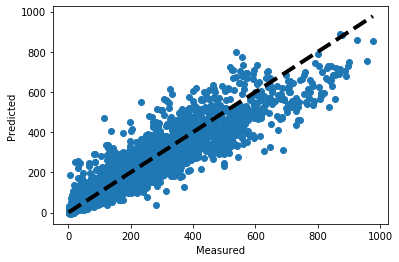

In [27]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# Improve performance


### คัดเลือก feature ใหม่

In [29]:
data=pd.read_csv('hour.csv')

In [30]:
data = data.drop(['instant' , 'dteday' ] , axis=1    )

In [31]:
x = data.iloc[:, 0:12]

In [32]:
x.columns

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

In [33]:
y= data.iloc[: , 12:14].values

In [34]:
#le_season = LabelEncoder()  ## แปลงcat เป็น numerical 
#x[:, 0] = le_season.fit_transform(x[:, 0])
#le_mnth = LabelEncoder()
#x[:, 1] = le_mnth.fit_transform(x[:, 1])
#le_hr = LabelEncoder()
#x[:, 2] = le_hr.fit_transform(x[:, 2])
#e_weekday = LabelEncoder()
#x[:, 4] = le_weekday.fit_transform(x[:, 4])
#le_weathersit = LabelEncoder()
#x[:, 6] = le_weathersit.fit_transform(x[:, 6])

In [35]:
ohe = OneHotEncoder(categorical_features = [0,2,3,5,7])  ## ทำให้เป็น binary : year, holiday ,working day
x = ohe.fit_transform(x).toarray()


C:\Users\peravit2\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\peravit2\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [37]:
x_test

array([[-0.57106566,  1.71031679, -0.58933902, ...,  0.31171606,
         1.31751766,  0.27350893],
       [-0.57106566, -0.58468701, -0.58933902, ..., -0.21784314,
         1.31751766, -1.55552756],
       [-0.57106566, -0.58468701, -0.58933902, ..., -0.21784314,
        -0.60381308, -0.45843243],
       ...,
       [-0.57106566, -0.58468701,  1.69681622, ...,  0.66475553,
         0.53859979, -0.70186828],
       [ 1.75111213, -0.58468701, -0.58933902, ..., -1.36551269,
         0.38281622, -0.70186828],
       [-0.57106566, -0.58468701, -0.58933902, ..., -1.10044181,
        -0.34417379,  0.27350893]])

In [41]:
classifier = Sequential()
classifier.add(Dense(units = 80 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 58))
classifier.add(Dense(units = 60, activation = 'relu'))
classifier.add(layers.Dropout(0.2))
classifier.add(Dense(units = 50, activation = 'relu'))
classifier.add(Dense(units = 40, activation = 'relu'))
classifier.add(Dense(units = 2, activation = 'linear' ))

W0913 00:24:42.350464 11812 deprecation.py:506] From C:\Users\peravit2\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [42]:
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse'])

In [43]:
x.shape

(17379, 58)

In [45]:
classifier.fit(x_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
13903/13903 [==============================] - 1s 84us/step - loss: 852.7680 - mean_squared_error: 852.7680
Epoch 2/100
13903/13903 [==============================] - 1s 100us/step - loss: 854.7717 - mean_squared_error: 854.7717
Epoch 3/100
13903/13903 [==============================] - 1s 98us/step - loss: 810.9947 - mean_squared_error: 810.9947
Epoch 4/100
13903/13903 [==============================] - 1s 106us/step - loss: 786.6412 - mean_squared_error: 786.6412
Epoch 5/100
13903/13903 [==============================] - 1s 104us/step - loss: 791.0548 - mean_squared_error: 791.0548
Epoch 6/100
13903/13903 [==============================] - 2s 115us/step - loss: 768.9949 - mean_squared_error: 768.9949
Epoch 7/100
13903/13903 [==============================] - 2s 110us/step - loss: 749.9471 - mean_squared_error: 749.9471
Epoch 8/100
13903/13903 [==============================] - 1s 86us/step - loss: 741.9153 - mean_squared_error: 741.9153
Epoch 9/100
13903/13903 [==========

In [46]:
y_pred = classifier.predict(x_test)

In [47]:
mean_squared_error(y_test, y_pred)

1384.887611622114